## Multisite Weather Generators using Bayesian Networks: 
### Worked Example using BNWeatherGen package

#### Mikel N. Legasa, José Manuel Gutiérrez.

This document presents the R code that reproduces the Bayesian network models of the paper *Multisite Weather Generators using Bayesian Networks: An illustrative case study for precipitation occurrence*, submitted to **Water Resources Research**. 

We briefly explain how to build the models presented in the paper, plot them, and use them to generate new precipitation series. In addittion, we also show a model which encompases a bigger number of stations, 44, to show the escalability of the approach.

This notebook makes use of the R package created for the purpose of using Bayesian networks as weather generators, [**BNWeatherGen**](https://github.com/MNLR/BNWeatherGen), and is included with the package. In turn, this package relies on [**bnlearn**](https://www.bnlearn.com), plus the packages [**gRain**](https://cran.r-project.org/web/packages/gRain/index.html) (Used for exact inference) and  [**iGraph**](https://igraph.org/c/) (for visualization). The reader can install the package by using `devtools::install_github("MNLR/BNWeatherGen")`, but this will not install all the required dependencies. We briefly describe the whole installation process in the following cells.

Firstly, some dependencies of `gRain` are installed through [Bioconductor](http://www.bioconductor.org), which can be installed with the following commands:

In [ ]:
install.packages("BiocManager")
BiocManager::install(version = "3.10")

Afterwards, `gRain` and its dependencies. With `gRain` installed, we can install the package `BNWeatherGen` from Github using `devtools` library.

In [ ]:
BiocManager::install(c("graph", "RBGL", "Rgraphviz"))
install.packages("gRain", dependencies = TRUE)
install.packages("devtools")
devtools::install_github("MNLR/BNWeatherGen")

Note that the package in itself is currently being worked on, with some features still being experimental and functionality being added, e.g. predictive models. Still, the examples and functionality reproduced here have been extensivelly tested.

The datasets used in the paper are packed as `ECA11.Germany.JJA` and `ECA11.Germany.DJF`. They are already in the adequate format to be used as input to the functions (see bellow). Note that their format is that of the [*Climate4R*](https://github.com/SantanderMetGroup/Climate4R) bundle, in particular the [loadeR](https://github.com/SantanderMetGroup/loadeR) library. They contain daily precipitation records used in the study, which range from 1979 to 2008, for a subset of 11 stations in southeast Germany extracted from the VALUE spatial validation experiment (A description of the experiment and the data can be found in https://doi.org/10.1002/joc.6024). Precipitation has been discretized to 0/1 absence/presence of precipitation, with `ECA11.Germany.DJF` containing observations from December, January and February are (DJF season) and `ECA11.Germany.JJA` containing observations from June, July and August (JJA season). Throughout this notebook we use the `ECA11.Germany.JJA` dataset. We also include the dataset `ECA44.Germany.JJA`, which contains 44 stations, for which we train a model and show that the approach is escalable to higher numbers of stations.

We load the library and visualize the data, which is a list with the binary series stored in `ECA11.Germany.JJA$Data`. The other elements, contain additional information like the coordinates of the stations, `ECA11.Germany.JJA$xyCoords`; and the dates, `ECA11.Germany.JJA$Dates`.

In [1]:
library(BNWeatherGen,  quietly = T)
head(ECA11.Germany.JJA$Data)


Attaching package: ‘bnlearn’


The following object is masked from ‘package:stats’:

    sigma



Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, parents




0,1,0,0,1,1,1,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,1,1,1,1,1
1,1,0,1,1,1,1,0,0,1,1


A descriptive network can be built using `buildDescriptive()`. For example, we replicate the Bayesian network shown in figure $1b$:

In [2]:
descriptive <- buildDescriptive(ECA11.Germany.JJA)

[1] "Removed 92 observations with NA values."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


Weather generators can be built using the function `buildWeatherGenerator`()`.

In [3]:
model <- buildWeatherGenerator(ECA11.Germany.JJA)

[1] "Removed 92 observations with NA values."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


By default, tabu search is employed to find the optimum Directed Acyclic Graph (DAG). There are many different configuration options. The structure learning algorithm can be any of the algorithm provided by the `bnlearn` package (see https://www.bnlearn.com). Parameter learning can be done either using Maximum Likelihood Estimation (`"mle"`) or in a Bayesian setting (`"bayes"`). `structure.learning.args.list` is used to tune the parameters for the structure learning algorithm.

For example, we train a model using Hill-Climbing algorithm and adjust the probability tables using Maximum Likelihood Estimation. We also modify the regularization parameter `k` in the score to $1.5$ and set the hill-climbing algorithm to restart $100$ times.

In [4]:
model.hc <- buildWeatherGenerator(ECA11.Germany.JJA, structure.learning.algorithm = "hc", 
                                  param.learning.method = "mle", 
                                  structure.learning.args.list = list(k = 1.5, 
                                                                      restart = 100), 
                                  )

[1] "Removed 92 observations with NA values."
[1] "Building Bayesian Network using hc..."


Warning message in check.penalty(k = extra.args$k, network = network, data = data, :
“using BIC with a non-standard penalty k = 1.5.”


[1] "Done building Bayesian Network."


The are many different configuration options, including e.g. the learning steps, the number of time slices considered and constraints to the learning algorithms. All of them are documented and can be checked with `?buildWeatherGenerator()`. As a final example, we reproduce figure $3b$ and $3c$, using the same parameters. Note that some variability can be expected:

In [5]:
model.figure3b <- buildWeatherGenerator(ECA11.Germany.JJA, 
                                        structure.learning.algorithm = "tabu", 
                                        param.learning.method = "bayes", 
                                        structure.learning.args.list = list(score = "aic", tabu = 10^4),
                                        structure.learning.args.list2 = list(score = "aic", tabu = 10^4),
                                        force.DD = NULL,
                                        structure.learning.steps = 2, fix.intermediate = FALSE
                                        )
model.figure3c <- buildWeatherGenerator(ECA11.Germany.JJA, 
                                        structure.learning.algorithm = "tabu", 
                                        param.learning.method = "bayes", 
                                        structure.learning.args.list = list(score = "aic", tabu = 10^4),
                                        force.DD = "->", 
                                        structure.learning.steps = 2,
                                        structure.learning.args.list2 = list(score = "aic", tabu = 10^4), 
                                        fix.intermediate = TRUE
                                        )

[1] "Building intermediate DAG..."
[1] "Done."
[1] "Removed 92 observations with NA values."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Building intermediate DAG..."
[1] "Done."
[1] "Removed 92 observations with NA values."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


We can plot both models and the descriptive network with the function `plotCBN()`

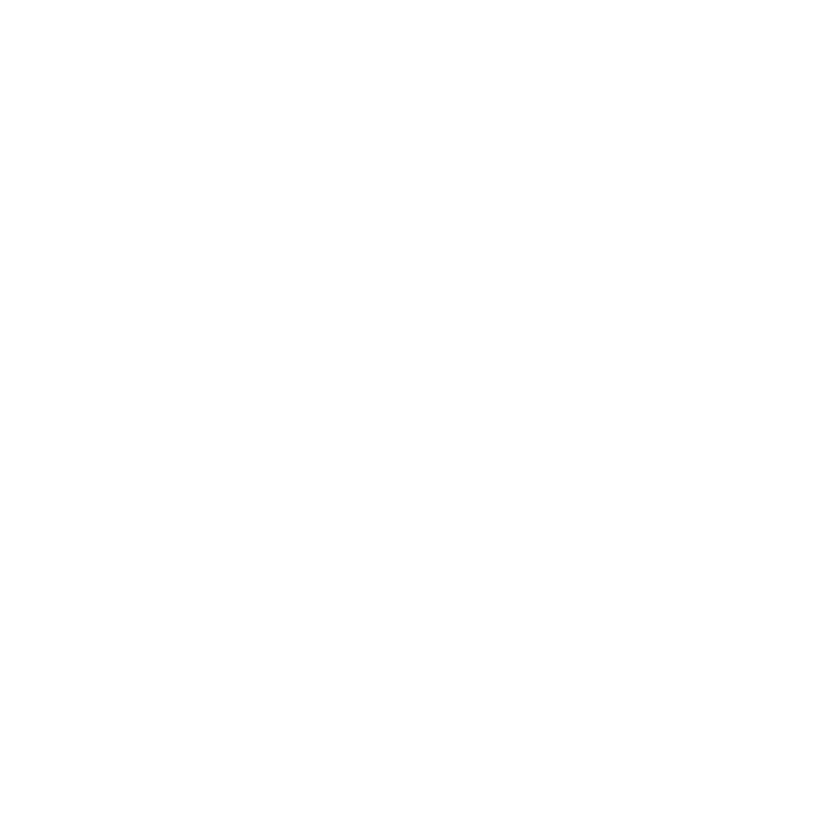

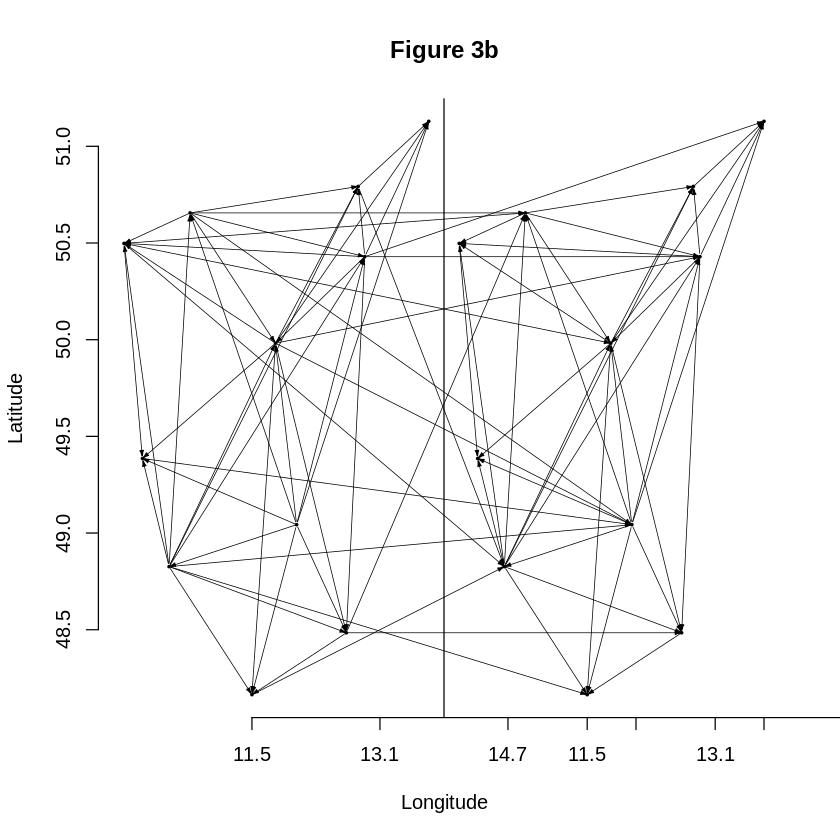

In [6]:
plotCBN(model.figure3b, vertex.label.dist = 0.5, title = "Figure 3b", 
        no.labels = T, return.plot = F, dev.new = F)

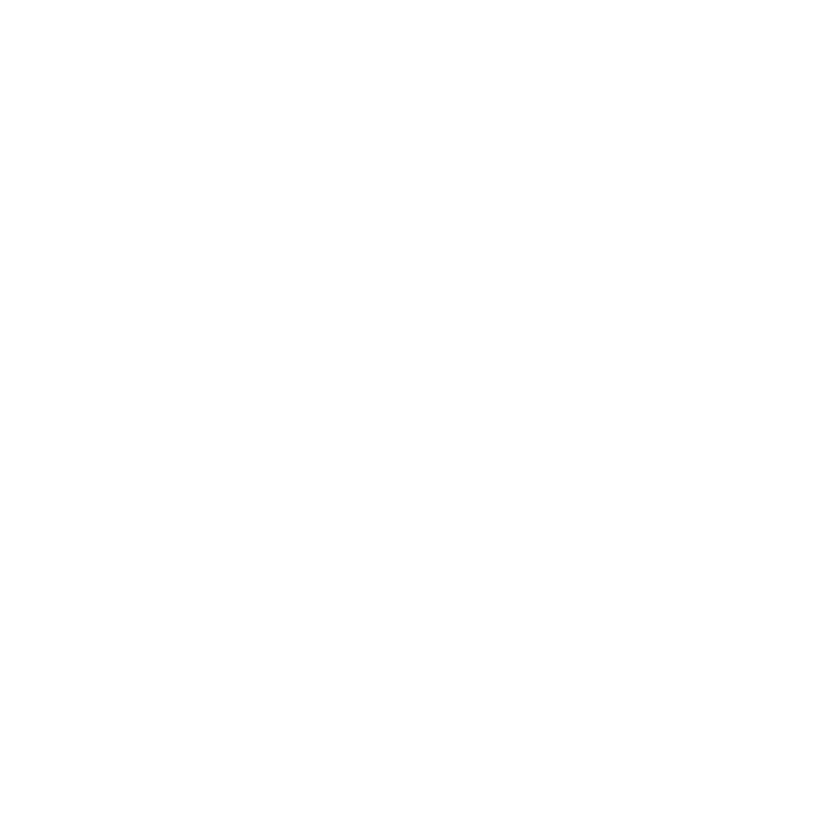

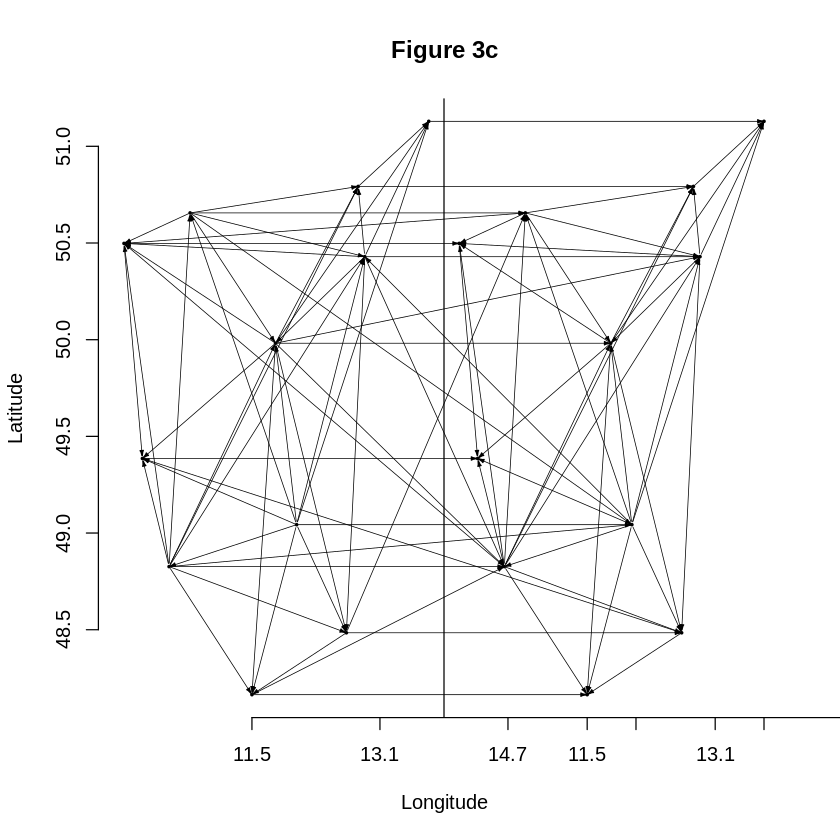

In [7]:
plotCBN(model.figure3c, vertex.label.dist = 0.5, title = "Figure 3c",
        no.labels = T, return.plot = F, dev.new = F)

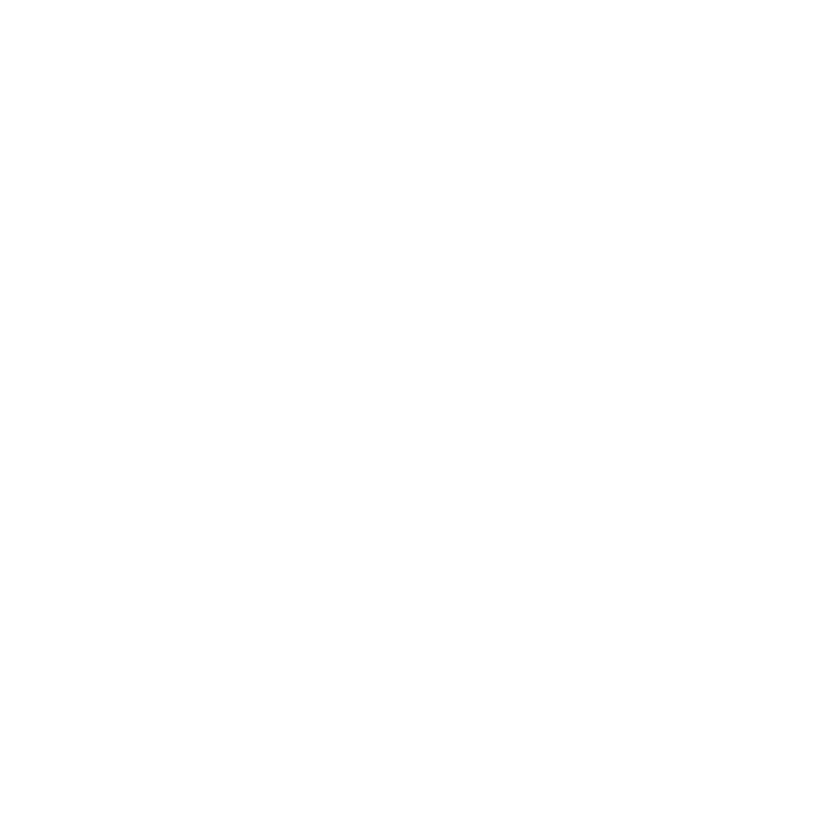

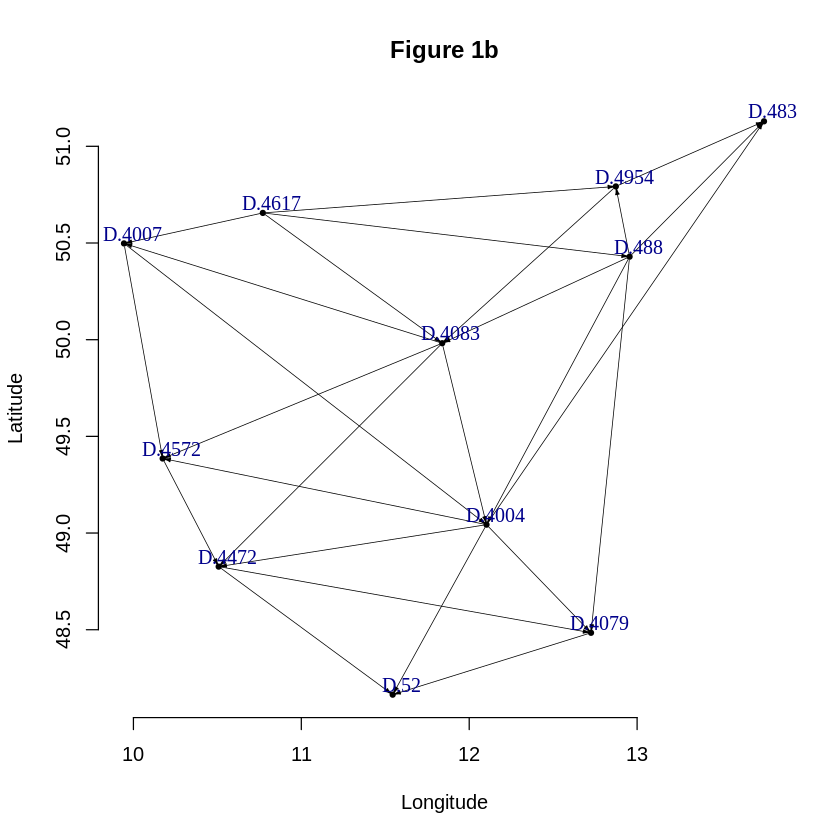

In [8]:
plotCBN(descriptive, dev.new = F, return.plot = F, title = "Figure 1b",
        vertex.label.dist = 1)

We can use the model to generate synthetic discrete precipitation series with the function `generateWeather()`

In [9]:
weather.series <- generateWeather(model.figure3c, n = 100)
head(weather.series)

[1] "Generating series of 100 slices ..."
  |======================================================================| 100%

,D.4004,D.4007,D.4079,D.4083,D.4472,D.4572,D.4617,D.483,D.488,D.4954,D.52
0,0,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,1,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,1,0,0,0,0,0,0


The descriptive network can be used to generate samples using `rbn()` function from `bnlearn`.

In [10]:
spatially.consistent.observations <- rbn(descriptive$BN.fit, n = 10)
head(spatially.consistent.observations)

,D.4004,D.4007,D.4079,D.4083,D.4472,D.4572,D.4617,D.483,D.488,D.4954,D.52
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,1,1,0,1,0,0,0,1
5,1,1,1,1,1,1,1,1,1,1,0
6,0,1,0,1,1,1,0,1,1,0,0


Finally, in order to show that the approach can be extended to bigger datasets, we build a model for the 44 stations of the dataset explained above, using the same parameters. We also display the computing time:

[1] "Building intermediate DAG..."
[1] "Done."
[1] "Removed 9 observations with NA values."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."


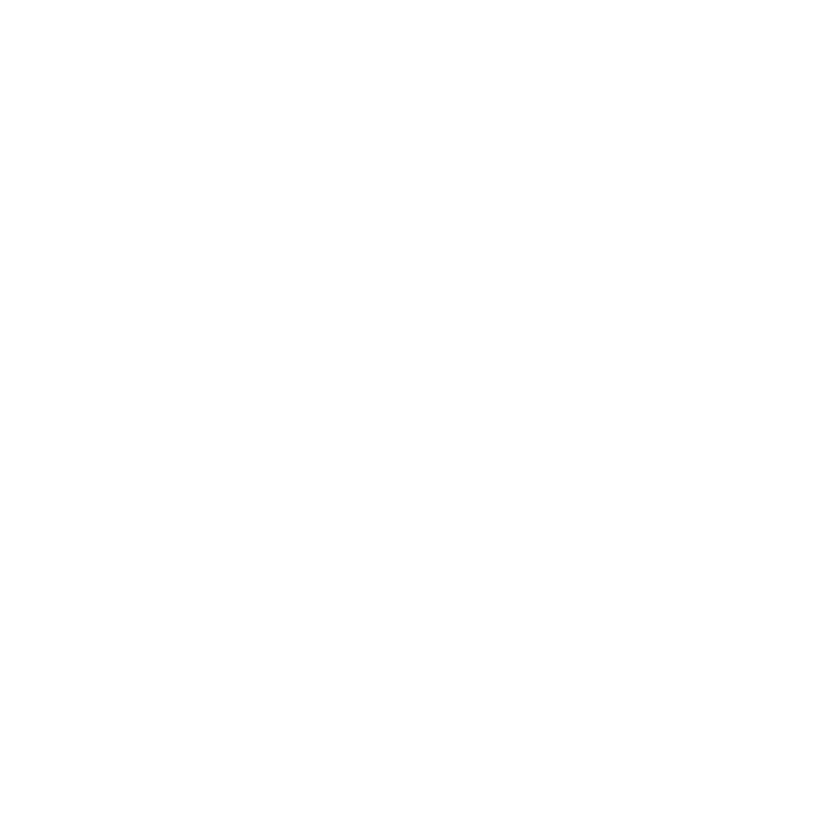

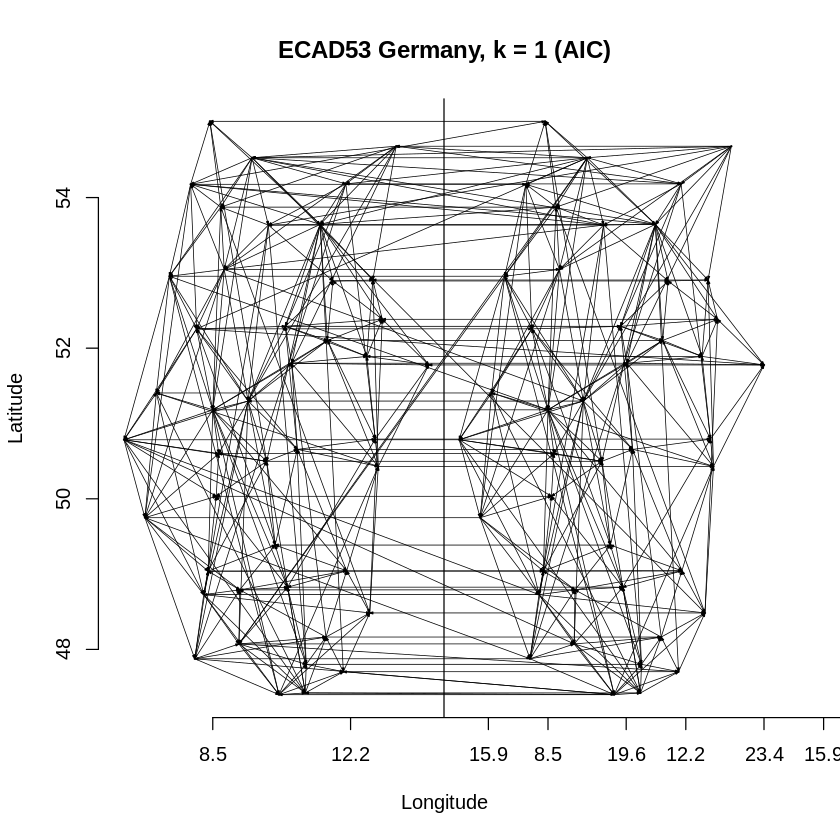

In [11]:
t0 <- Sys.time()
model.44 <- buildWeatherGenerator(ECA44.Germany.JJA, 
                                        structure.learning.algorithm = "tabu", 
                                        param.learning.method = "bayes", 
                                        structure.learning.args.list = list(score = "aic", tabu = 10^4),
                                        force.DD = "-", 
                                        structure.learning.steps = 2,
                                        structure.learning.args.list2 = list(score = "aic", tabu = 10^4), 
                                        fix.intermediate = TRUE)
time.train <- Sys.time() - t0
plotCBN(model.44, no.labels = T, title = "ECAD53 Germany, k = 1 (AIC)", edge.arrow.size = 0.1 , return.plot = F)

The model requires approximately $8$ minutes to train:

In [12]:
time.train

Time difference of 7.898521 mins

Similarly, we simulate 100 observations, which require ~5 minutes:

In [13]:
t0 <- Sys.time()
weather.series <- generateWeather(model.44, n = 100)
time.simulate <- Sys.time() - t0
time.simulate

[1] "Process will approximately take 0 hours and 4 minutes."
[1] "Generating series of 100 slices ..."
  |======================================================================| 100%

Time difference of 4.630339 mins